# Multi-Agent Researcher with MCP Support

This notebook demonstrates how to use the multi-agent research system with Model Context Protocol (MCP) support. It follows the same patterns as the original multi_agent.ipynb but adds MCP integration.

In [1]:
%cd ..
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

/Users/bartolli/Projects/playgound/open_deep_research_05/open_deep_research/src


In [2]:
import uuid 
import os
import open_deep_research   
print(open_deep_research.__version__) 
from IPython.display import Image, display, Markdown
from langgraph.checkpoint.memory import MemorySaver
import logging

# Set up logging for better visibility
logging.basicConfig(level=logging.INFO)

0.0.15


## Configure MCP Server

We'll use the example MCP server that provides patient data.

In [4]:
# Get the path to the example_mcp_server.py 
import pathlib
repo_root = pathlib.Path(".").resolve()
example_server_path = str(repo_root / "open_deep_research" / "example_mcp_server.py")

# Check if file exists
print(f"Example MCP server path: {example_server_path}")
print(f"File exists: {pathlib.Path(example_server_path).exists()}")

# Try alternate locations if not found
if not pathlib.Path(example_server_path).exists():
    alternate_path = str(repo_root / "open_deep_research" / "example_mcp_server.py")
    print(f"Trying alternate path: {alternate_path}")
    print(f"Alternate path exists: {pathlib.Path(alternate_path).exists()}")
    if pathlib.Path(alternate_path).exists():
        example_server_path = alternate_path

# Define MCP server configuration
mcp_servers_config = {
    "patient_data": {
        "transport": "stdio",
        "command": "python",
        "args": [example_server_path],
    }
}

Example MCP server path: /Users/bartolli/Projects/playgound/open_deep_research_05/open_deep_research/src/open_deep_research/example_mcp_server.py
File exists: True


## Build the Graph with MCP Support

Instead of directly using supervisor_g.compile(), we'll use the build_graph_with_mcp function.

In [5]:
# Import the build_graph_with_mcp function
from open_deep_research.multi_agent_new import build_graph_with_mcp, supervisor_g

# Create a MemorySaver for checkpointing
checkpointer = MemorySaver()

# Create base configuration with proper model specifications
base_config = {
    "thread_id": str(uuid.uuid4()),
    "search_api": "tavily",
    "supervisor_model": "anthropic:claude-3-5-sonnet-latest",  # Use appropriate model
    "researcher_model": "anthropic:claude-3-5-sonnet-latest",  # Use appropriate model
    "mcp_servers": mcp_servers_config,
    "_mcp_servers_config": mcp_servers_config,
}

# This is a notebook-specific adaptation that combines build_graph_with_mcp with checkpointer
async def build_graph_with_checkpointer(cfg):
    # First get the MCP configuration but don't create the manager yet (like in build_graph_with_mcp)
    from open_deep_research.configuration import Configuration
    
    cfg = cfg or {}
    configurable = Configuration.from_runnable_config(cfg)
    mcp_servers = configurable.mcp_servers
    
    # Store MCP servers config in a special key (same as build_graph_with_mcp)
    if mcp_servers:
        print(f"MCP servers configured: {list(mcp_servers.keys())}")
        if "configurable" not in cfg:
            cfg["configurable"] = {}
        cfg["configurable"]["_mcp_servers_config"] = mcp_servers
    
    # Now compile with checkpointer (different from build_graph_with_mcp)
    g = supervisor_g.compile(name="research_team", checkpointer=checkpointer)
    
    # Apply config after compilation
    g = g.with_config(cfg)
    
    # Return in the same format as build_graph_with_mcp
    return g, None, cfg

# Build the graph using our adapted function
agent, _, thread_config = await build_graph_with_checkpointer(base_config)

MCP servers configured: ['patient_data']


## Visualize the Graph Structure

This shows how supervisor and research agents are connected in the workflow.

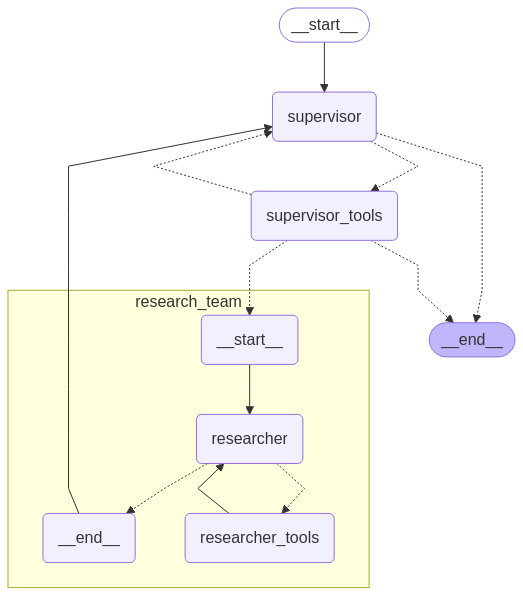

In [38]:
display(Image(agent.get_graph(xray=1).draw_mermaid_png(max_retries=5)))

## Run the Multi-Agent System

We'll use a focused query that leverages the patient data from the MCP server.

In [6]:
# Define the research topic as a user message
msg = [{"role": "user", "content": "Check what we know about patient with id P001 and conduct  research on the latest treatment approaches and management strategies for these conditions."}]

# Create a properly structured config dictionary for invoking the agent
access_config = {
    "configurable": {
        "thread_id": base_config["thread_id"],
        "mcp_servers": base_config["mcp_servers"],
        "_mcp_servers_config": base_config["_mcp_servers_config"],
    }
}

# Run the multi-agent workflow with the properly structured configuration
response = await agent.ainvoke({"messages": msg}, config=access_config)

INFO:open_deep_research.multi_agent_new:Supervisor tools available: ['tavily_search', 'Sections', 'Introduction', 'Conclusion']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:open_deep_research.mcp_integration:Creating MCP manager with servers: ['patient_data']
INFO:open_deep_research.mcp_integration:Initializing MCP client with servers: ['patient_data']
INFO:open_deep_research.mcp_integration:Server patient_data config: transport=stdio
INFO:open_deep_research.mcp_integration:  Command: python /Users/bartolli/Projects/playgound/open_deep_research_05/open_deep_research/src/open_deep_research/example_mcp_server.py
INFO:open_deep_research.mcp_integration:Successfully loaded 3 tools from MCP servers
INFO:open_deep_research.mcp_integration:Tool 1: patient_vitals - 
Retrieve current vital signs for a patient.

Args:
    patient_id: Unique identifier for the patient
    
Returns:
    Dictionary containing vital measurements including:
    - hea

## View the Supervisor's Response

In [7]:
# Create a properly structured config dictionary for state access
access_config = {
    "configurable": {
        "thread_id": base_config["thread_id"],
        "mcp_servers": base_config["mcp_servers"],
        "_mcp_servers_config": base_config["_mcp_servers_config"],
    }
}

# Then use this properly structured config to access the state
messages = agent.get_state(access_config).values['messages']
messages[-1].pretty_print()

================================== Ai Message ==================================

Here’s a summary of what we currently know about patient P001:

- Vital signs: All most recent vitals are within normal limits (heart rate 72, blood pressure 120/80 mmHg, temperature 36.8°C, respiratory rate 16, oxygen saturation 98%).
- Active/current conditions:
  - Type 2 Diabetes Mellitus (moderate severity, managed, diagnosed July 2023)
  - Essential Hypertension (mild severity, active, diagnosed March 2022)
- Upcoming scheduled check: HbA1c test scheduled for May 10, 2025 (routine priority).

To ensure thorough research, I’d like a bit more context:

1. Is the focus of your request primarily on pharmacological (medication), lifestyle (diet/exercise), technological (devices, apps), or procedural interventions—or a combination?
2. Are you seeking guidance specifically on new/emerging therapies, or is a review of standard-of-care management with recent updates sufficient?
3. Should the research address

## Add Clarification if Needed

If the supervisor asks for clarification, we can add more details.

In [8]:
# Create a follow-up message with your clarification
follow_up_msg = [
    {"role": "user", "content": "Focus on the latest integrated management approaches for these comorbid conditions from recent medical literature in 2024-2025. Include both pharmacological and lifestyle interventions."}
]

# Create a properly structured config dictionary for state access
access_config = {
    "configurable": {
        "thread_id": base_config["thread_id"],
        "mcp_servers": base_config["mcp_servers"],
        "_mcp_servers_config": base_config["_mcp_servers_config"],
    }
}

# Run the multi-agent workflow again with your clarification
response = await agent.ainvoke({"messages": follow_up_msg}, config=access_config)

# Check the response
messages = agent.get_state(access_config).values['messages']
messages[-1].pretty_print()

INFO:open_deep_research.multi_agent_new:Supervisor tools available: ['tavily_search', 'Sections', 'Introduction', 'Conclusion']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:open_deep_research.mcp_integration:Creating MCP manager with servers: ['patient_data']
INFO:open_deep_research.mcp_integration:Initializing MCP client with servers: ['patient_data']
INFO:open_deep_research.mcp_integration:Server patient_data config: transport=stdio
INFO:open_deep_research.mcp_integration:  Command: python /Users/bartolli/Projects/playgound/open_deep_research_05/open_deep_research/src/open_deep_research/example_mcp_server.py
INFO:open_deep_research.mcp_integration:Successfully loaded 3 tools from MCP servers
INFO:open_deep_research.mcp_integration:Tool 1: patient_vitals - 
Retrieve current vital signs for a patient.

Args:
    patient_id: Unique identifier for the patient
    
Returns:
    Dictionary containing vital measurements including:
    - hea

================================== Ai Message ==================================

Thank you for clarifying your focus. Here’s what we have so far for patient P001:

- Diagnoses: Comorbid Type 2 Diabetes Mellitus (moderate, managed) and Essential Hypertension (mild, active).
- Latest vitals are stable and routine HbA1c testing is scheduled.
- Your requested scope: Most up-to-date (2024-2025) integrated management strategies for these comorbidities, with specific attention to both pharmacological and lifestyle interventions, based on recent literature.

Based on current medical sources—including diabetesjournals.org and articles indexed in PubMed Central—recent integrated approaches emphasize:
- Pharmacological: Personalized use of therapies with proven cardiovascular and renal benefits (e.g., SGLT2 inhibitors, GLP-1 receptor agonists), antihypertensives, statins as indicated.
- Lifestyle: Evidence-based guidance on healthy nutrition, physical activity, stress reduction, obesity/weight m

In [9]:
# Create a follow-up message with your clarification
confirmation_msg = [
    {"role": "user", "content": "Looks good to me. Go ahead with the research."}
]

# Create a properly structured config dictionary for state access
access_config = {
    "configurable": {
        "thread_id": base_config["thread_id"],
        "mcp_servers": base_config["mcp_servers"],
        "_mcp_servers_config": base_config["_mcp_servers_config"],
    }
}

# Run the multi-agent workflow again with your clarification
response = await agent.ainvoke({"messages": confirmation_msg}, config=access_config)

# Check the response
messages = agent.get_state(access_config).values['messages']
messages[-1].pretty_print()

INFO:open_deep_research.multi_agent_new:Supervisor tools available: ['tavily_search', 'Sections', 'Introduction', 'Conclusion']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:open_deep_research.mcp_integration:Creating MCP manager with servers: ['patient_data']
INFO:open_deep_research.mcp_integration:Initializing MCP client with servers: ['patient_data']
INFO:open_deep_research.mcp_integration:Server patient_data config: transport=stdio
INFO:open_deep_research.mcp_integration:  Command: python /Users/bartolli/Projects/playgound/open_deep_research_05/open_deep_research/src/open_deep_research/example_mcp_server.py
INFO:open_deep_research.mcp_integration:Successfully loaded 3 tools from MCP servers
INFO:open_deep_research.mcp_integration:Tool 1: patient_vitals - 
Retrieve current vital signs for a patient.

Args:
    patient_id: Unique identifier for the patient
    
Returns:
    Dictionary containing vital measurements including:
    - hea

================================== Ai Message ==================================

# Integrated Management of Comorbid Type 2 Diabetes and Hypertension: 2024-2025 Update

Comorbid type 2 diabetes mellitus and hypertension are two of the most prevalent chronic conditions worldwide, frequently occurring together and compounding the risk of cardiovascular, renal, and other complications. Over recent years, new evidence has emphasized the need for integrated, person-centered management strategies that leverage both pharmacological innovation and lifestyle intervention. This report synthesizes the latest (2024–2025) advances in the integrated care of these high-risk patients—including updates in therapeutics, behavioral science, models of multidisciplinary care, and future directions—drawing on authoritative clinical literature and guideline updates. The goal is to provide clinicians and healthcare stakeholders with an evidence-based overview of the most effective and emerging strategies for

/Users/bartolli/Projects/playgound/open_deep_research_05/open_deep_research/.venv/lib/python3.13/site-packages/langgraph/checkpoint/serde/jsonplus.py:526: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  return cls(**tup[2])


## View the Final Report

Once all sections are completed, introduction and conclusion are added, the final report will be available.

In [10]:
# Create the properly structured access config
access_config = {
    "configurable": {
        "thread_id": base_config["thread_id"],
        "mcp_servers": base_config["mcp_servers"],
        "_mcp_servers_config": base_config.get("_mcp_servers_config", base_config["mcp_servers"]),
    }
}

# Check if the final report is available
if 'final_report' in agent.get_state(access_config).values:
    display(Markdown(agent.get_state(access_config).values['final_report']))
else:
    print("Report is still being generated. More interactions may be needed.")
    
    # Show current state and message count
    print(f"\nCurrent message count: {len(agent.get_state(access_config).values['messages'])}")
    print(f"Most recent message type: {agent.get_state(access_config).values['messages'][-1].get('role') if isinstance(agent.get_state(access_config).values['messages'][-1], dict) else agent.get_state(access_config).values['messages'][-1].role}")
    
    # Check for completed sections
    if 'completed_sections' in agent.get_state(access_config).values:
        print(f"\nCompleted sections: {len(agent.get_state(access_config).values['completed_sections'])}")
        for i, section in enumerate(agent.get_state(access_config).values['completed_sections']):
            print(f"\nSection {i+1}: {section.name}")

# Integrated Management of Comorbid Type 2 Diabetes and Hypertension: 2024-2025 Update

Comorbid type 2 diabetes mellitus and hypertension are two of the most prevalent chronic conditions worldwide, frequently occurring together and compounding the risk of cardiovascular, renal, and other complications. Over recent years, new evidence has emphasized the need for integrated, person-centered management strategies that leverage both pharmacological innovation and lifestyle intervention. This report synthesizes the latest (2024–2025) advances in the integrated care of these high-risk patients—including updates in therapeutics, behavioral science, models of multidisciplinary care, and future directions—drawing on authoritative clinical literature and guideline updates. The goal is to provide clinicians and healthcare stakeholders with an evidence-based overview of the most effective and emerging strategies for improving outcomes in this challenging patient population.

## Overview of Comorbid Type 2 Diabetes and Hypertension: Epidemiology and Clinical Significance

- Comorbidity of type 2 diabetes and hypertension is highly prevalent. Most adults with type 2 diabetes have at least one additional chronic disease, with up to 40% reporting three or more comorbidities, hypertension being the most common.
- The coexistence of these conditions substantially increases the risk of cardiovascular events, kidney disease, and overall mortality.
- Quality of life decreases significantly as the number of comorbidities increases, with pronounced impacts on physical function and daily activities.
- Integrated, person-centered care involving multidisciplinary teams is linked to better clinical outcomes, improved quality of life, and greater care coordination compared to fragmented management.
- Recent studies underscore the importance of collaborative approaches for these high-risk patients, highlighting benefits in metabolic and blood pressure control, and patient-reported outcomes.

### Sources
1. https://diabetesjournals.org/care/article/29/3/725/25400/The-Impact-of-Comorbid-Chronic-Conditions-on
2. https://pubmed.ncbi.nlm.nih.gov/26267523/
3. https://drc.bmj.com/content/bmjdrc/8/1/e000842.full.pdf

## Pharmacological Interventions in Integrated Management: Recent Advances (2024-2025)

- **GLP-1 receptor agonists** (e.g., semaglutide, tirzepatide) now have robust evidence for reducing major adverse cardiovascular events (MACE) in obesity, type 2 diabetes, and heart failure, with absolute event risk reductions up to 2.3% in high-risk groups. Their renal benefits have also been documented in chronic kidney disease cohorts.
- **Novel agents**: Finerenone (non-steroidal mineralocorticoid receptor antagonist) lowers heart failure events and CV mortality in heart failure with preserved ejection fraction. RNA-based drugs and tafamidis/acoramidis have expanded options for ATTR amyloidosis.
- **Statins & antihypertensives**: Guideline algorithms increasingly emphasize individualized risk. Adoption of the PREVENT risk calculator reduces statin and antihypertensive eligibility by up to 15.8 million US adults, albeit with minimal up-classification to higher-risk. High-intensity statins are now prioritized for diabetics with ASCVD risk factors and LDL-C over 70 mg/dL.
- **Anti-inflammatory therapies**: Colchicine is FDA-approved for secondary prevention after positive RCTs. Ongoing trials target additional inflammatory pathways for further risk reduction.

### Sources
1. https://www.acc.org/latest-in-cardiology/articles/2025/01/01/42/cover-story-transformative-trends-in-cv-medicine-for-2025
2. https://jamanetwork.com/journals/jama/fullarticle/2821624
3. https://www.heart.org/en/around-the-aha/aha-names-biggest-advances-in-cardiovascular-research-for-2024

## Lifestyle and Behavioral Interventions: Evidence-Based Approaches and Emerging Trends

- **Dietary strategies:** Individualized, calorie-restricted diets (typically 500–700 kcal/day deficit) and healthy eating patterns are foundational. Mediterranean, low-carbohydrate, and plant-centric diets improve glycemic control and support >5% weight loss, with very low-calorie or meal replacement protocols considered for remission in select cases.
- **Physical activity:** At least 150 minutes of moderate or 75 minutes of vigorous aerobic activity per week is recommended, coupled with resistance training ≥2 times/week. Both diet and exercise are crucial for sustained weight loss and improvement in HbA1c.
- **Behavioral therapies:** Cognitive Behavioral Therapy (CBT) and self-monitoring enhance adherence, weight loss, and long-term maintenance. Goal-setting, problem-solving, and structured follow-up are effective.
- **Stress and sleep management:** CBT-based or integrated interventions addressing sleep, stress, and mental health reduce diabetes distress and improve self-management.
- **Implementation:** Multidisciplinary teams, digital self-monitoring tools, and tailoring interventions to cultural/lifestyle factors boost real-world success.

### Sources
1. https://www.nature.com/articles/s41598-023-40141-5
2. https://www.bmj.com/content/361/bmj.k2234
3. https://www.ncbi.nlm.nih.gov/books/NBK574576/
4. https://pmc.ncbi.nlm.nih.gov/articles/PMC8802999/
5. https://diabetesjournals.org/care/article/48/Supplement_1/S167/157555/8-Obesity-and-Weight-Management-for-the-Prevention

## Integrated Care Models and Multidisciplinary Approaches

- **Core Models:** Integrated care for comorbid populations includes case management, patient-centred medical homes (PCMH), and multidisciplinary teams. These ensure coordinated care across settings, targeting patients with complex needs.
- **Taxonomies:** Integration spans organizational, functional, service, and clinical levels, ranging from micro (individual) to macro (population) approaches.
- **Multidisciplinary Teams:** Co-locating primary and specialty care, with licensed mental health or allied professionals, improves outcomes such as reduced hospital admissions and higher patient satisfaction.
- **Digital Health Tools:** EHRs/shared care plans, telemedicine, and AI-enhanced decision support streamline communication, monitor outcomes, and personalize interventions. Examples include Canada’s iCOACH project and the NHS, where around 50% of patients have digital tool access.
- **Outcomes:** Evidence shows integrated models enhance continuity, decrease fragmentation, and improve patient-reported outcomes—especially for multimorbid or older adults. Successful implementation depends on digital readiness and staff training.

### Sources
1. https://iris.who.int/bitstream/handle/10665/375502/WHO-EURO-2016-6525-46291-66959-eng.pdf?sequence=1
2. https://pmc.ncbi.nlm.nih.gov/articles/PMC8516005/
3. https://www.sciencedirect.com/science/article/pii/S2666869622000434

## Challenges, Barriers, and Future Directions in Integrated Management

- **Adherence**: Organizations struggle to maintain consistent implementation due to complexity, limited integration of all relevant systems (especially economic management), and varying process maturity (Sources 5, 1).
- **Equity**: True integration should address all stakeholder needs, including social responsibility and equity throughout supply networks. Current systems often underperform in covering the full range of stakeholder interests—especially marginalized groups and supply chain stakeholders (Source 5).
- **System-Level Integration**: Barriers include fragmented standards, insufficient stakeholder engagement, and lack of flexible frameworks adaptable to diverse organizational contexts. Integration is often partial, not holistic (Sources 5, 7).
- **Research Gaps**:
  - Absence of quantitative measures on integration impacts (Source 2)
  - Limited models integrating equity and all stakeholder needs
  - Insufficient study on sustained adherence in dynamic environments
- **Innovative Directions**:
  - Process-based, stakeholder-driven integration using frameworks like ISO 26000
  - Comprehensive supply-chain monitoring and stakeholder analysis
  - Agile IMS models responsive to emergent risks

### Sources
1. https://www.sciencedirect.com/science/article/pii/S0959652620301682
2. https://www.tandfonline.com/doi/full/10.1080/14783363.2021.1893685
3. https://www.diva-portal.org/smash/get/diva2:391834/FULLTEXT01.pdf
4. https://www.mdpi.com/2071-1050/14/6/3559

## Conclusion

Integrated management of comorbid type 2 diabetes and hypertension has evolved substantially in the 2024–2025 medical literature. The convergence of innovative pharmacological therapies—such as GLP-1 receptor agonists, SGLT2 inhibitors, and personalized statin and antihypertensive regimens—with strengthened behavioral and lifestyle approaches forms the core of contemporary best practice. Multidisciplinary and digitally enabled care models further enhance coordination, adherence, and patient experience. Nevertheless, challenges remain, particularly in the realms of health equity, holistic integration, and the measurement of long-term adherence and outcomes. As research continues to identify gaps and propose new frameworks, the future of integrated care is likely to become even more patient-centered, digitally sophisticated, and inclusive. Stakeholders should remain attentive to evolving evidence and invest in agile, team-based, and equitable delivery models to optimize care for complex, multimorbid populations.

## Optional: Continue the Research Process

If the report isn't complete, you can continue with further interactions.

In [11]:
# Optional: Request elaboration on a specific section or topic
# Uncomment and modify when you want to explore a specific area in more detail

# Create a list of possible section names if they exist in the state
access_config = {
    "configurable": {
        "thread_id": base_config["thread_id"],
        "mcp_servers": base_config["mcp_servers"],
        "_mcp_servers_config": base_config.get("_mcp_servers_config", base_config["mcp_servers"]),
    }
}

# Check if there are completed sections to reference
if 'completed_sections' in agent.get_state(access_config).values:
    section_names = [section.name for section in agent.get_state(access_config).values['completed_sections']]
    print("Available sections that could be elaborated:")
    for i, name in enumerate(section_names):
        print(f"{i+1}. {name}")



Available sections that could be elaborated:
1. Overview of Comorbid Type 2 Diabetes and Hypertension: Epidemiology and Clinical Significance
2. Pharmacological Interventions in Integrated Management: Recent Advances (2024-2025)
3. Lifestyle and Behavioral Interventions: Evidence-Based Approaches and Emerging Trends
4. Integrated Care Models and Multidisciplinary Approaches
5. Challenges, Barriers, and Future Directions in Integrated Management


In [12]:
# If you want to elaborate on a specific section, uncomment and modify the following lines
# Choose a specific section to elaborate on

# Choose a specific topic to elaborate on
elaborate_topic = "Lifestyle and Behavioral Interventions: Evidence-Based Approaches and Emerging Trends"

# Request elaboration within the current thread
elaborate_msg = [
    {"role": "user", "content": f"Now that we have a good understanding of Patient P001's condition from the report, I'd like more detailed information specifically about '{elaborate_topic}'. Please create a focused mini-report that goes deeper into this topic, including the most recent clinical evidence, medication classes, dosing considerations, and monitoring recommendations. Focus specifically on how this applies to Patient P001's clinical profile of moderate Type 2 Diabetes (HbA1c 7.8%) and mild Hypertension (BP 135/88)."}
]

# Run the process for the elaboration using the SAME thread configuration
elaborate_response = await agent.ainvoke({"messages": elaborate_msg}, config=access_config)

# Check the response
elaborate_messages = agent.get_state(access_config).values['messages']
elaborate_messages[-1].pretty_print()

INFO:open_deep_research.multi_agent_new:Supervisor tools available: ['tavily_search', 'Sections', 'Introduction', 'Conclusion']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:open_deep_research.mcp_integration:Creating MCP manager with servers: ['patient_data']
INFO:open_deep_research.mcp_integration:Initializing MCP client with servers: ['patient_data']
INFO:open_deep_research.mcp_integration:Server patient_data config: transport=stdio
INFO:open_deep_research.mcp_integration:  Command: python /Users/bartolli/Projects/playgound/open_deep_research_05/open_deep_research/src/open_deep_research/example_mcp_server.py
INFO:open_deep_research.mcp_integration:Successfully loaded 3 tools from MCP servers
INFO:open_deep_research.mcp_integration:Tool 1: patient_vitals - 
Retrieve current vital signs for a patient.

Args:
    patient_id: Unique identifier for the patient
    
Returns:
    Dictionary containing vital measurements including:
    - hea

================================== Ai Message ==================================

Here is a focused mini-report of lifestyle and behavioral interventions for Patient P001, synthesizing the latest clinical evidence (2024–2025) and detailing practical strategies—including their relationships to medication classes and specific monitoring approaches—tailored to moderate type 2 diabetes (HbA1c 7.8%) and mild hypertension (BP 135/88):

---

## Evidence-Based Lifestyle and Behavioral Interventions in Moderate Type 2 Diabetes (HbA1c 7.8%) and Mild Hypertension (BP 135/88)

### 1. Dietary Interventions

**Key Recommendations (2024–2025):**
- Adopt either the Mediterranean or DASH diet, as both have independent and synergistic effects on glycemic and blood pressure control.
  - **Mediterranean Diet**: Emphasizes vegetables, legumes, fruit, nuts, seeds, olive oil, whole grains, fish, and lean poultry. Associated with 9%–25% relative reduction in T2DM incidence and improved microvascular outcomes.